In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pycaret.classification import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    print("⚠️ XGBoost não disponível. Instale com: pip install xgboost")
    XGB_AVAILABLE = False

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = False

In [6]:
# %% utils
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, eps, None))) * 100

def plot_series(dates, y_true, y_pred, title):
    plt.figure()
    plt.plot(dates, y_true, label="Real")
    plt.plot(dates, y_pred, label="Previsto")
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Vendas Semanais")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_series_multi(dates, y_true, **preds):
    plt.figure()
    plt.plot(dates, y_true, label="Real")
    for name, arr in preds.items():
        plt.plot(dates, arr, label=name)
    plt.title("Real x Modelos")
    plt.xlabel("Data")
    plt.ylabel("Vendas Semanais")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scatter(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, s=10)
    mn = min(np.min(y_true), np.min(y_pred))
    mx = max(np.max(y_true), np.max(y_pred))
    plt.plot([mn, mx], [mn, mx])
    plt.title(title)
    plt.xlabel("Real")
    plt.ylabel("Previsto")
    plt.tight_layout()
    plt.show()

def plot_error_over_time(dates, y_true, y_pred, title):
    err = np.array(y_true) - np.array(y_pred)
    plt.figure()
    plt.plot(dates, err)
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Erro (real - previsto)")
    plt.tight_layout()
    plt.show()

def plot_error_box_by_month(dates, y_true, y_pred, title):
    df_tmp = pd.DataFrame({
        "date": pd.to_datetime(dates),
        "err": np.array(y_true) - np.array(y_pred)
    })
    df_tmp["month"] = df_tmp["date"].dt.month
    data = [df_tmp[df_tmp["month"] == m]["err"].values for m in sorted(df_tmp["month"].unique())]
    plt.figure()
    plt.boxplot(data, labels=sorted(df_tmp["month"].unique()))
    plt.title(title)
    plt.xlabel("Mês")
    plt.ylabel("Erro")
    plt.tight_layout()
    plt.show()

def plot_feature_importance(importances, feature_names, title):
    idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,4))
    plt.bar(range(len(idx)), np.array(importances)[idx])
    plt.xticks(range(len(idx)), np.array(feature_names)[idx], rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def iterative_forecast(model, X_test_scaled, lag_positions, scaler, original_X_test):
    Xt = X_test_scaled.copy()
    preds = []
    for i in range(Xt.shape[0]):
        p = model.predict(Xt[i].reshape(1, -1))[0]
        preds.append(p)
        if i + 1 < Xt.shape[0]:
            # vamos montar linha de referência pra escalar o novo lag
            ref = original_X_test.iloc[[i+1]].copy()
            ref["Weekly_Sales_lag_1"] = p
            ref_scaled = scaler.transform(ref.values)
            Xt[i+1, lag_positions["Weekly_Sales_lag_1"]] = ref_scaled[0, lag_positions["Weekly_Sales_lag_1"]]
    return np.array(preds)

In [7]:
# %% 1) carregar
DATA_PATH = Path("sales.csv")
df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

if (df["Fuel_Price"] > 100).any():
    df["Fuel_Price"] = df["Fuel_Price"] / 1000.0
if (df["Unemployment"] > 100).any():
    df["Unemployment"] = df["Unemployment"] / 1000.0

In [8]:
df.head(5)

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [10]:
s = setup(df, target='Holiday_Flag')
s

,Description,Value
0,Session id,1703
1,Target,Holiday_Flag
2,Target type,Binary
3,Original data shape,"(143, 7)"
4,Transformed data shape,"(143, 9)"
5,Transformed train set shape,"(100, 9)"
6,Transformed test set shape,"(43, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


In [14]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9300,0.4667,0.0000,0.0000,0.0000,nan,0.0000,0.1210
svm,SVM - Linear Kernel,0.9300,0.2222,0.0000,0.0000,0.0000,nan,0.0000,0.0440
rf,Random Forest Classifier,0.9300,0.4333,0.0000,0.0000,0.0000,nan,0.0000,0.2170
qda,Quadratic Discriminant Analysis,0.9300,0.3556,0.0000,0.0000,0.0000,nan,0.0000,0.0500
xgboost,Extreme Gradient Boosting,0.9300,0.4000,0.0000,0.0000,0.0000,nan,0.0000,0.0620
dummy,Dummy Classifier,0.9300,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.0370
et,Extra Trees Classifier,0.9200,0.4000,0.0000,0.0000,0.0000,nan,-0.0111,0.1960
lr,Logistic Regression,0.9100,0.3889,0.0000,0.0000,0.0000,nan,-0.0111,0.1400
nb,Naive Bayes,0.9100,0.4444,0.0000,0.0000,0.0000,nan,-0.0111,0.0610
ridge,Ridge Classifier,0.9100,0.4556,0.0000,0.0000,0.0000,nan,-0.0111,0.0430


In [21]:
modelx = compare_models(n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9300,0.4667,0.0000,0.0000,0.0000,nan,0.0000,0.0680
svm,SVM - Linear Kernel,0.9300,0.2222,0.0000,0.0000,0.0000,nan,0.0000,0.0540
rf,Random Forest Classifier,0.9300,0.4333,0.0000,0.0000,0.0000,nan,0.0000,0.2690
qda,Quadratic Discriminant Analysis,0.9300,0.3556,0.0000,0.0000,0.0000,nan,0.0000,0.0540
xgboost,Extreme Gradient Boosting,0.9300,0.4000,0.0000,0.0000,0.0000,nan,0.0000,0.0570
dummy,Dummy Classifier,0.9300,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.0430
et,Extra Trees Classifier,0.9200,0.4000,0.0000,0.0000,0.0000,nan,-0.0111,0.2970
lr,Logistic Regression,0.9100,0.3889,0.0000,0.0000,0.0000,nan,-0.0111,0.1440
nb,Naive Bayes,0.9100,0.4444,0.0000,0.0000,0.0000,nan,-0.0111,0.0450
ridge,Ridge Classifier,0.9100,0.4556,0.0000,0.0000,0.0000,nan,-0.0111,0.0560


In [24]:
evaluate_model(modelx[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [5]:
# %% 2) feature engineering
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)
df["quarter"] = df["Date"].dt.quarter
df["is_month_start"] = df["Date"].dt.is_month_start.astype(int)
df["is_month_end"] = df["Date"].dt.is_month_end.astype(int)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

In [6]:
# lags
for lag in [1, 2, 3, 4, 12, 52]:
    df[f"Weekly_Sales_lag_{lag}"] = df["Weekly_Sales"].shift(lag)

In [7]:
# rolling (deslocando 1 pra não vazar)
df["Weekly_Sales_roll_4"] = df["Weekly_Sales"].rolling(4).mean().shift(1)
df["Weekly_Sales_roll_12"] = df["Weekly_Sales"].rolling(12).mean().shift(1)

In [8]:
# descarta início com NaN
df = df.dropna().reset_index(drop=True)

In [9]:
# %% 3) split temporal
cutoff = pd.Timestamp("2012-01-01")
train_df = df[df["Date"] < cutoff].copy()
test_df  = df[df["Date"] >= cutoff].copy()

In [10]:
target = "Weekly_Sales"
feature_cols = [
    "Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment",
    "year","month","weekofyear","quarter",
    "is_month_start","is_month_end",
    "month_sin","month_cos",
    "Weekly_Sales_lag_1","Weekly_Sales_lag_2","Weekly_Sales_lag_3",
    "Weekly_Sales_lag_4","Weekly_Sales_lag_12","Weekly_Sales_lag_52",
    "Weekly_Sales_roll_4","Weekly_Sales_roll_12"
]

X_train = train_df[feature_cols].copy()
y_train = train_df[target].copy()
X_test  = test_df[feature_cols].copy()
y_test  = test_df[target].copy()

In [11]:
# %% 4) scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled  = scaler.transform(X_test.values)

In [12]:
# posições dos lags (pra atualizar no iterativo)
lag_positions = {col: feature_cols.index(col) for col in feature_cols if "lag_" in col}

In [13]:
# %% 5) modelos
rf = RandomForestRegressor(
    n_estimators=700,
    max_depth=14,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

xgb_model = None
if XGB_AVAILABLE:
    xgb_model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train_scaled, y_train)

In [14]:
# %% 6) forecast iterativo
pred_rf = iterative_forecast(
    model=rf,
    X_test_scaled=X_test_scaled,
    lag_positions=lag_positions,
    scaler=scaler,
    original_X_test=X_test
)

pred_xgb = None
if xgb_model is not None:
    pred_xgb = iterative_forecast(
        model=xgb_model,
        X_test_scaled=X_test_scaled,
        lag_positions=lag_positions,
        scaler=scaler,
        original_X_test=X_test
    )

In [15]:
# %% 7) métricas
results = [{
    "Modelo": "RandomForest_V2",
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_rf)),
    "R2": r2_score(y_test, pred_rf),
    "MAPE": mape(y_test, pred_rf)
}]
if pred_xgb is not None:
    results.append({
        "Modelo": "XGBoost_V2",
        "RMSE": np.sqrt(mean_squared_error(y_test, pred_xgb)),
        "R2": r2_score(y_test, pred_xgb),
        "MAPE": mape(y_test, pred_xgb)
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

            Modelo          RMSE        R2      MAPE
0  RandomForest_V2  75076.544800  0.564276  3.434496
1       XGBoost_V2  92337.465289  0.340888  4.219404


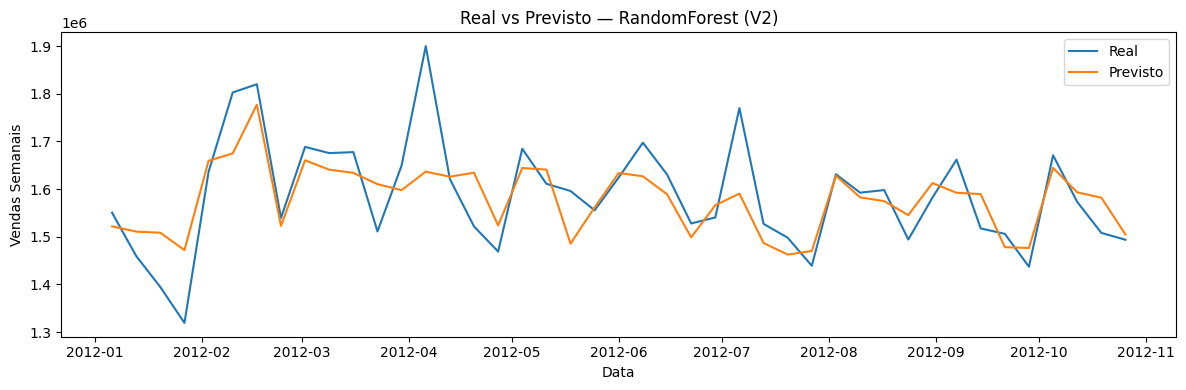

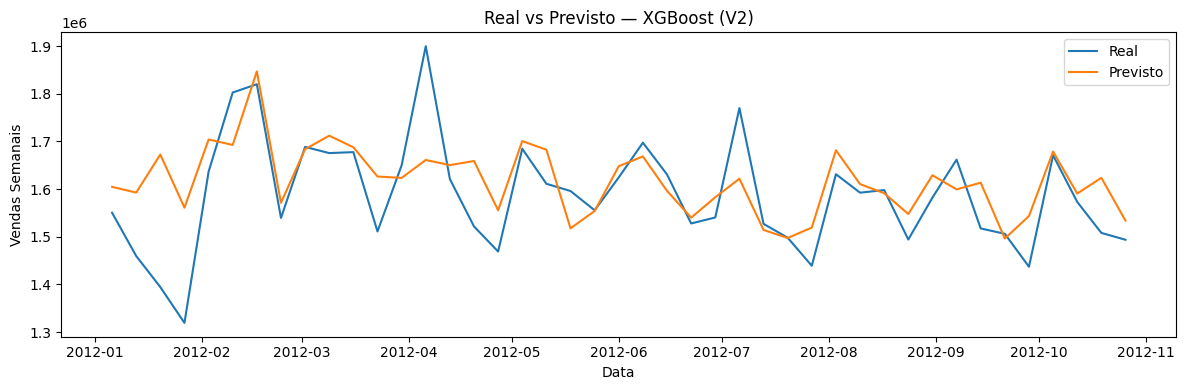

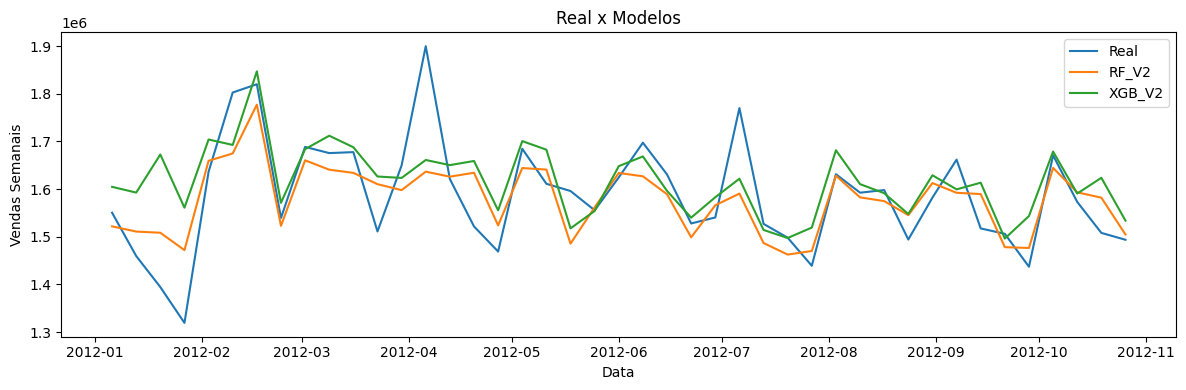

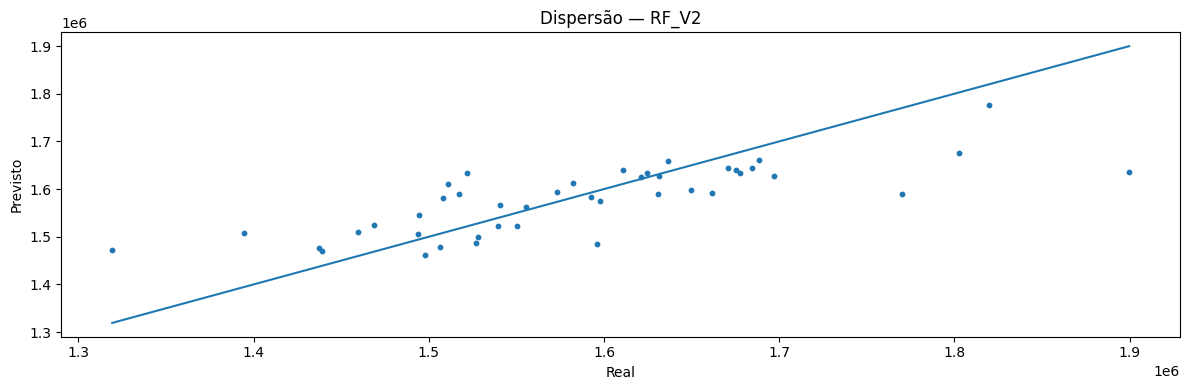

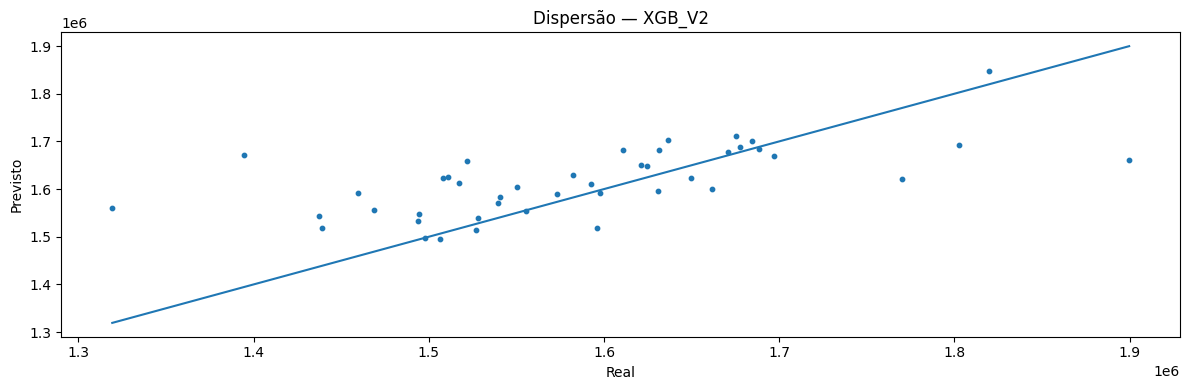

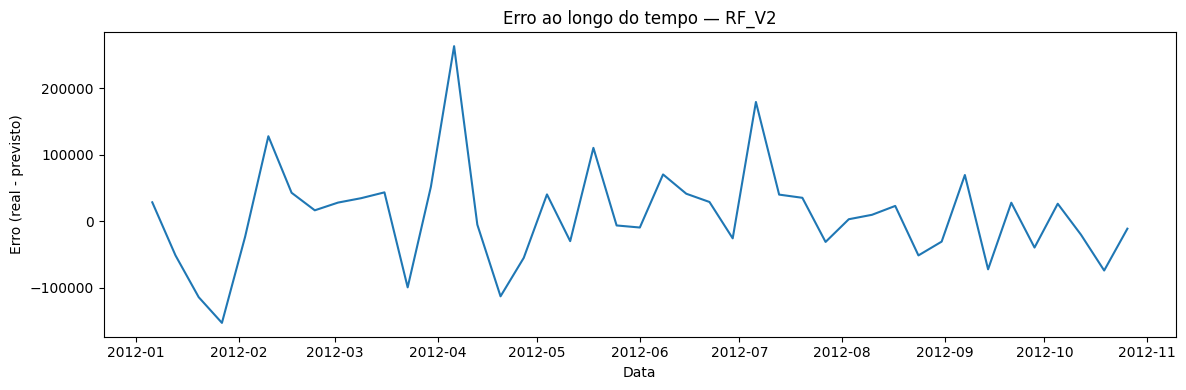

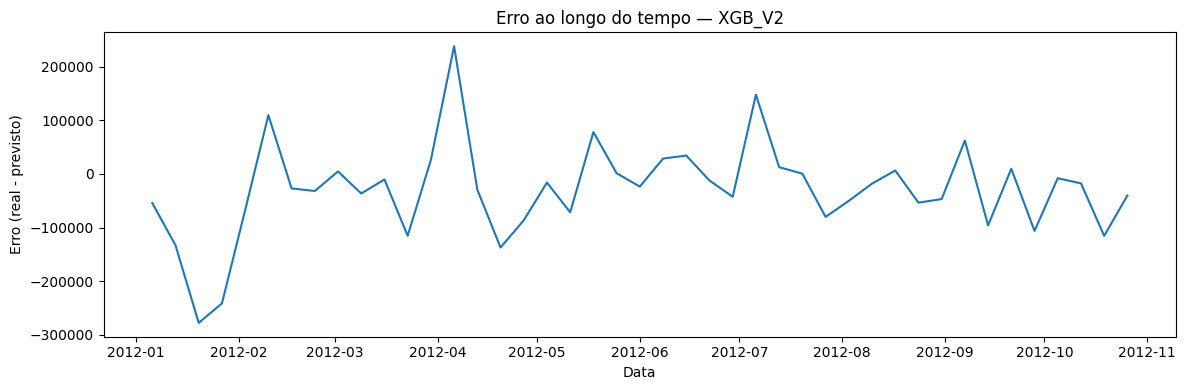

C:\Users\helde\AppData\Local\Temp\ipykernel_11808\3134459514.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df_tmp["month"].unique()))


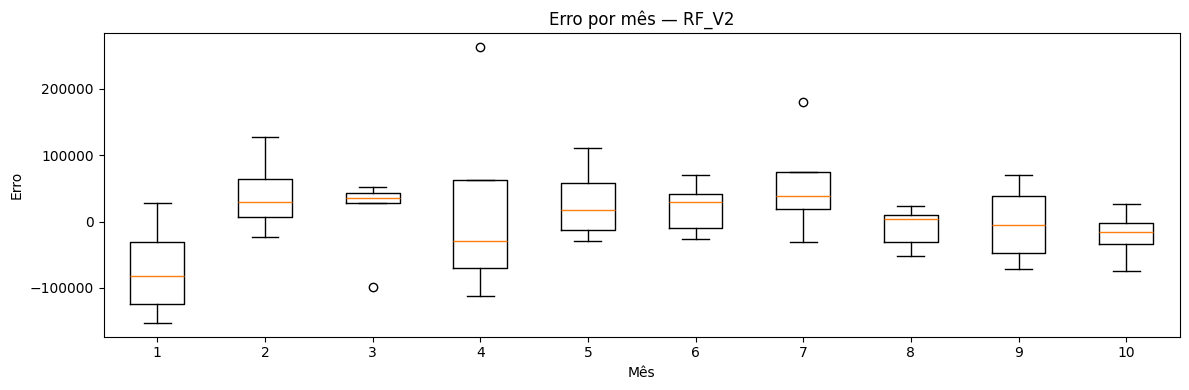

C:\Users\helde\AppData\Local\Temp\ipykernel_11808\3134459514.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df_tmp["month"].unique()))


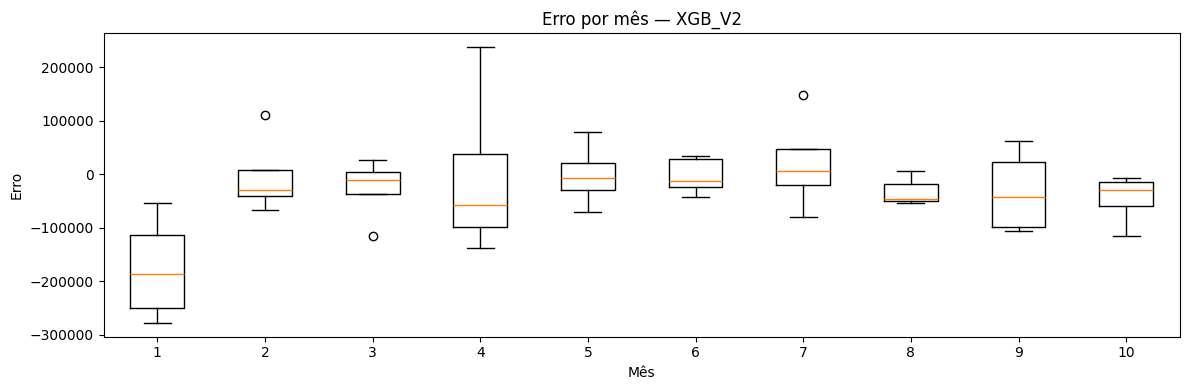

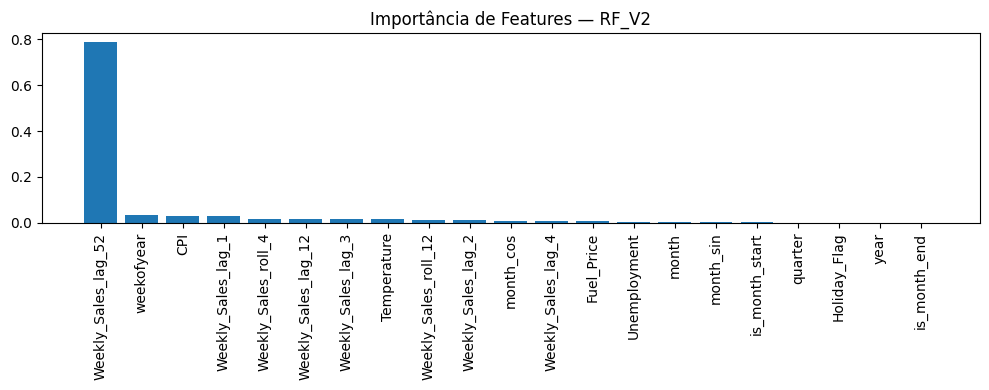

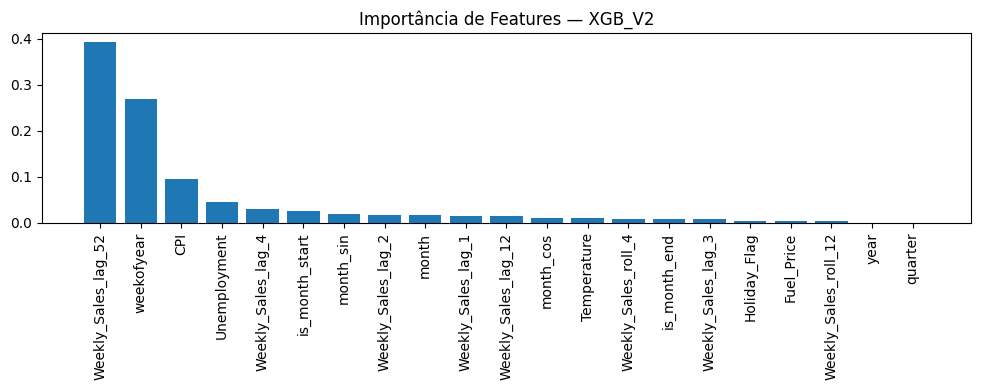

In [16]:
# %% 8) gráficos de comparação
dates_test = test_df["Date"]

# 8.1 — cada modelo separado
plot_series(dates_test, y_test.values, pred_rf, "Real vs Previsto — RandomForest (V2)")
if pred_xgb is not None:
    plot_series(dates_test, y_test.values, pred_xgb, "Real vs Previsto — XGBoost (V2)")

# 8.2 — comparação no mesmo gráfico
if pred_xgb is not None:
    plot_series_multi(
        dates_test,
        y_test.values,
        RF_V2=pred_rf,
        XGB_V2=pred_xgb
    )

# 8.3 — scatter
plot_scatter(y_test.values, pred_rf, "Dispersão — RF_V2")
if pred_xgb is not None:
    plot_scatter(y_test.values, pred_xgb, "Dispersão — XGB_V2")

# 8.4 — erro ao longo do tempo
plot_error_over_time(dates_test, y_test.values, pred_rf, "Erro ao longo do tempo — RF_V2")
if pred_xgb is not None:
    plot_error_over_time(dates_test, y_test.values, pred_xgb, "Erro ao longo do tempo — XGB_V2")

# 8.5 — boxplot por mês
plot_error_box_by_month(dates_test, y_test.values, pred_rf, "Erro por mês — RF_V2")
if pred_xgb is not None:
    plot_error_box_by_month(dates_test, y_test.values, pred_xgb, "Erro por mês — XGB_V2")

# 8.6 — importância de features
plot_feature_importance(rf.feature_importances_, feature_cols, "Importância de Features — RF_V2")
if xgb_model is not None:
    plot_feature_importance(xgb_model.feature_importances_, feature_cols, "Importância de Features — XGB_V2")


In [21]:
df.iloc[1][0]

C:\Users\helde\AppData\Local\Temp\ipykernel_11808\1019881219.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[1][0]


Timestamp('2011-02-11 00:00:00')